# DeepWeeds - Image Classification - Using ResNet50 Model

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import os
import shutil

seed = 679
tf.random.set_seed(seed)

2024-02-26 10:07:17.507742: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-26 10:07:17.507830: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-26 10:07:17.626680: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
## Downloading DeepWeeds Data  ## For Google Colab
# url = 'https://drive.google.com/uc?export=download&id=1xnK3B6K6KekDI55vwJ0vnc2IGoDga9cj'
# !gdown 1xnK3B6K6KekDI55vwJ0vnc2IGoDga9cj
# !unzip -qq images.zip -d images

In [3]:
# data_info = pd.read_csv('https://raw.githubusercontent.com/AlexOlsen/DeepWeeds/master/labels/labels.csv') ## for GoogleColab
data_info = pd.read_csv("/kaggle/input/deepweeds/labels.csv") ## For Kaggle
data_info

,Filename,Label,Species
0,20160928-140314-0.jpg,0,Chinee apple
1,20160928-140337-0.jpg,0,Chinee apple
2,20160928-140731-0.jpg,0,Chinee apple
3,20160928-140747-0.jpg,0,Chinee apple
4,20160928-141107-0.jpg,0,Chinee apple
...,...,...,...
17504,20180322-133822-1.jpg,8,Negative
17505,20180322-133832-1.jpg,8,Negative
17506,20180322-133840-1.jpg,8,Negative
17507,20180322-133850-1.jpg,8,Negative


In [4]:
data_info[['Species','Label']].groupby(by='Species').count().T

Species,Chinee apple,Lantana,Negative,Parkinsonia,Parthenium,Prickly acacia,Rubber vine,Siam weed,Snake weed
Label,1125,1064,9106,1031,1022,1062,1009,1074,1016


In [5]:
label2id = data_info[['Species','Label']].groupby(by='Species').min().to_dict()['Label']
id2label = {label2id[i]:i for i in label2id}
id2label

{0: 'Chinee apple',
 1: 'Lantana',
 8: 'Negative',
 2: 'Parkinsonia',
 3: 'Parthenium',
 4: 'Prickly acacia',
 5: 'Rubber vine',
 6: 'Siam weed',
 7: 'Snake weed'}

In [6]:
low_data_labels = data_info[data_info['Species'] != "Negative"]['Label'].unique() ## labels with very low data
low_data_labels

array([0, 1, 7, 6, 4, 3, 5, 2])

## Splitting Data into Train:Valid:Test Splits (60:40:40)

In [7]:
# colabAI prompt: train test split using data_info
from sklearn.model_selection import train_test_split, StratifiedKFold

### K-Fold Validation-----
#####---------------------
split_index = 2 # index to retrieve
print("Using KFold: Index",split_index+1,"out of 5 folds")
print("-------------------------------------------------\n")

# skfold = StratifiedKFold()
# kSplits = skfold.split(data_info['Filename'], y=data_info['Label'])
# for index in range(skfold.get_n_splits()):
#     train_index, test_index = next(kSplits)
#     if index == split_index:
#         break
        
# # trax, tex, tray, tey = train_test_split(data_info['Filename'],data_info['Label'], test_size=0.4, random_state=seed)
# # train_data = pd.DataFrame({"Filename":trax,"label":tray})

# # trax, tex, tray, tey = train_test_split(tex,tey, test_size=0.5, random_state=seed)
# # valid_data = pd.DataFrame({"Filename":trax,"label":tray})
# # test_data = pd.DataFrame({"Filename":tex,"label":tey})

Using KFold: Index 3 out of 5 folds
-------------------------------------------------



In [8]:
## Using Folds Used in The DeepWeeds Paper
train_data = pd.read_csv('https://raw.githubusercontent.com/AlexOlsen/DeepWeeds/master/labels/train_subset{}.csv'.format(split_index)) ## for GoogleColab
train_data.rename(columns={"Label":"label"}, inplace=True)

valid_data = pd.read_csv('https://raw.githubusercontent.com/AlexOlsen/DeepWeeds/master/labels/val_subset{}.csv'.format(split_index)) ## for GoogleColab
valid_data.rename(columns={"Label":"label"}, inplace=True)
test_data = pd.read_csv('https://raw.githubusercontent.com/AlexOlsen/DeepWeeds/master/labels/test_subset{}.csv'.format(split_index)) ## for GoogleColab
test_data.rename(columns={"Label":"label"}, inplace=True)

print("Is There Duplicates: ", not valid_data[valid_data['Filename'].isin(test_data['Filename'])].empty)
print("Train Data\n--------\n",train_data.groupby(by='label').count().T, "\tTotal:", train_data.shape)
print("Validation Data\n--------\n",valid_data.groupby(by='label').count().T, "\tTotal:", valid_data.shape)
print("Test Data\n--------\n",test_data.groupby(by='label').count().T, "\tTotal:", test_data.shape)

Is There Duplicates:  False
Train Data
--------
 label       0    1    2    3    4    5    6    7     8
Filename  676  638  619  613  637  605  644  610  5464 	Total: (10506, 2)
Validation Data
--------
 label       0    1    2    3    4    5    6    7     8
Filename  225  212  206  205  213  202  215  203  1821 	Total: (3502, 2)
Test Data
--------
 label       0    1    2    3    4    5    6    7     8
Filename  225  213  206  204  212  202  215  203  1821 	Total: (3501, 2)


# Helper Functions

- Organize Images to Directory as per Label for Creating Generator (organize_data_to_directory)
- Dataset Generator (getDatasetGenerators)
- Class Weights For Imbalanced Dataset (getWeightedClass)
- Accuracy / Loss plot (plot_loss_acc)
- Evaluation Metrics Calculation (eval_model, print_stats)
- Prediction with Threshold as used by DeepWeeds Author (prediction_argmax)

In [9]:
from tqdm.auto import tqdm

def organize_data_to_directory(data_info,source_dir='',target_dir='',oversample=0,oversampling_labels=[]):
    for index, row in tqdm(data_info.iterrows()):
        filename = row['Filename']
        label = row['label']

        source = os.path.join(source_dir,filename)
        
        #if not os.path.exists(source):
        #    print("File Doesn't Exist", source)
        #    continue

        target_path = os.path.join(target_dir,str(label))
        target = os.path.join(target_path,filename)
        # print(source,target)

        if not os.path.exists(target_path):
            os.mkdir(target_path)

        if not os.path.exists(target):
            if oversample and (label in oversampling_labels):
                for i in range(oversample):
                    sample_filename = os.path.join(target_path, "oversample-"+str(i)+"-"+filename)
                    shutil.copy(source, sample_filename)

            shutil.copy(source,target)

##-----------------------------
###----------------------------

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import image_dataset_from_directory

def getDatasetGenerators(train_dir, **kwargs):
    # --------------------
    # Flow training images in batches using generator
    # --------------------
    generator = image_dataset_from_directory(
        train_dir,
        **kwargs
    )

    return generator

In [10]:
from sklearn.utils import class_weight

def getWeightedClass(data, power=1, col="Label"):

    class_weights = class_weight.compute_class_weight('balanced',
                                                 classes=np.unique(data_info[col]),
                                                 y=data_info[col])

    return  { label: pow(class_weights[label],power) for label in range(len(class_weights)) }

getWeightedClass(data_info)

{0: 1.729283950617284,
 1: 1.8284252297410193,
 2: 1.8869490246793836,
 3: 1.9035659926070885,
 4: 1.8318685917555975,
 5: 1.9280916198656535,
 6: 1.8114007862611214,
 7: 1.9148075240594926,
 8: 0.21364423945139957}

In [11]:
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def prediction_argmax(prediction, rand_guess=1):
    l_pred = np.argmax(prediction[low_data_labels])
    if(prediction[l_pred] > rand_guess):
        return l_pred

    return np.argmax(prediction)

def printStats(actual_labels,prediction, use_rand_guess= 0):
    if use_rand_guess:
        prediction = [prediction_argmax(x, rand_guess=use_rand_guess) for x in prediction]
    else:
        prediction = [np.argmax(x) for x in prediction]

    print("Statistics")
    print("F1-Score",f1_score(actual_labels,prediction,average='weighted'))
    print("Precision-Score",precision_score(actual_labels,prediction,average='weighted'))
    print("Recall-Score",recall_score(actual_labels,prediction,average='weighted'))
    print("accuracy_Score",accuracy_score(actual_labels,prediction))
    print()

    n_class = np.unique(actual_labels).shape[0]
    cmd = ConfusionMatrixDisplay(tf.math.confusion_matrix(actual_labels,prediction,num_classes=n_class).numpy())
    cmd.plot()
    plt.show()
    
def eval_model(model, data_gen, use_rand_guess=False):
    print("model.evaluate")
    model.evaluate(data_gen)

    print("model.predict")
    actual_labels = []
    pred_prob = []
    for batch in tqdm(data_gen):
        actual_labels.extend([np.argmax(z) for z in batch[1]])
        pred_prob.extend(list(model.predict_on_batch(batch[0])))

    printStats(actual_labels,pred_prob,use_rand_guess)
    return actual_labels, pred_prob

def plot_loss_acc(history):
    '''Plots the training and validation loss and accuracy from a history object'''
    acc = history['accuracy']
    val_acc = history['val_accuracy']
    loss = history['loss']
    val_loss = history['val_loss']
    
    epochs = range(len(acc))
    
    plt.figure(figsize=[16, 4])
    plt.subplot(1,2,1)
    plt.plot(epochs, acc, label='Training accuracy', color='red')
    plt.plot(epochs, val_acc, label='Validation accuracy', color='magenta')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(epochs, loss, label='Training Loss', color='red')
    plt.plot(epochs, val_loss, label='Validation Loss', color='magenta')
    plt.title('Training and validation loss')
    plt.legend()
    
    plt.show()

# Creating Dateset ImageGenerator

In [12]:
IMG_SIZE=(256,256,3)
oversampling = 1 # How many times are we gonna over sample

if oversampling:
    print("Oversampling",oversampling,"times for labels",low_data_labels)

# base_dir = '/content/dataset_9c' ## For GoogleColab
# input_dir = '/content/images' ## For GoogleColab

input_dir = "/kaggle/input/deepweeds/images" ## For Kaggle
base_dir = "/kaggle/working/deepweeds_9c" ## For Kaggle

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

if os.path.exists(base_dir):
    shutil.rmtree(base_dir)

os.mkdir(base_dir)
os.mkdir(train_dir)
os.mkdir(validation_dir)
os.mkdir(test_dir)

## Organizing Training Data
organize_data_to_directory(train_data, source_dir=input_dir, target_dir=train_dir, oversample=oversampling, oversampling_labels=low_data_labels)

# ## Organizing Validation Data
organize_data_to_directory(valid_data, source_dir=input_dir, target_dir=validation_dir)

# ## Organizing Test Data
organize_data_to_directory(test_data, source_dir=input_dir, target_dir=test_dir)

Oversampling 1 times for labels [0 1 7 6 4 3 5 2]


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [13]:
train_generator = getDatasetGenerators(
      train_dir,
      batch_size=16,
      label_mode='categorical',
      image_size = IMG_SIZE[:2],
      shuffle=True
)

test_generator = getDatasetGenerators(
      test_dir,
      batch_size=8,
      label_mode='categorical',
      image_size = IMG_SIZE[:2],
      shuffle=False
)

validation_generator = getDatasetGenerators(
      validation_dir,
      batch_size=8,
      label_mode='categorical',
      image_size = IMG_SIZE[:2],
      shuffle=True
)

Found 15548 files belonging to 9 classes.
Found 3501 files belonging to 9 classes.
Found 3502 files belonging to 9 classes.


## Displaying Sample Images

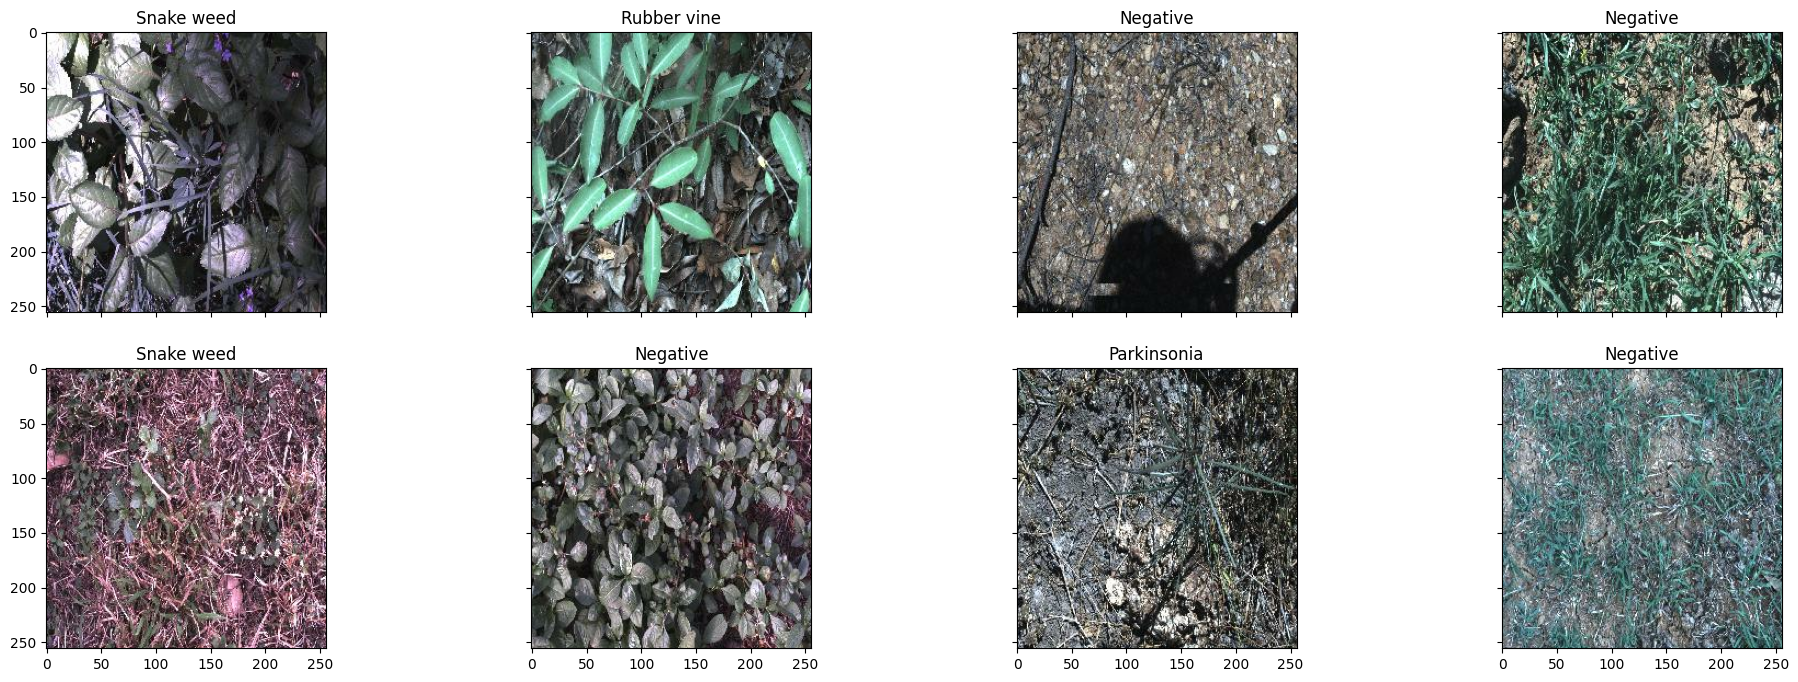

In [14]:
#image visualization

fig, ax = plt.subplots(2, 4, sharex=True, sharey=True, figsize=(24,8))

for images, labels in validation_generator:
    for i in range(2):
        for j in range(4):
            ax[i][j].imshow(images[i+j*2].numpy().astype(np.int32))
            ax[i][j].set_title(id2label[np.argmax(labels[i+j*2])])

    break
plt.show()

# ResNet50

In [15]:
# prompt: code to implement resnet

import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.layers as layers
from tensorflow.keras.applications import ResNet50V2, resnet_v2

def buildResNetModel(train_resnet=False):
    # Load the ResNet50 model with weights pre-trained on ImageNet.
    base_model = ResNet50V2(weights='imagenet', include_top=False)
    base_model.trainable = train_resnet

    # Define the input layer.
    inputs = keras.Input(shape=IMG_SIZE)

    # PreProcess the input.
    x = layers.Rescaling(1./255)(inputs)
    x = layers.Resizing(224, 224)(x)
    
    ## Augmentation
    x = layers.RandomBrightness(0.25, (0, 1),seed=seed)(x)
    x = layers.RandomContrast(0.1, seed=seed)(x)
    x = layers.GaussianDropout(0.05, seed=seed)(x)
    x = layers.RandomFlip(seed=seed)(x)
    x = layers.RandomRotation(0.5, seed=seed)(x)
    x = layers.RandomTranslation(0.2, 0.2, seed=seed)(x)
    x = layers.RandomZoom(0.2, 0.2, seed=seed)(x)

    # Pass the input through the pre-trained ResNet50 model.
    x = base_model(x, training=train_resnet)    
    x = layers.Dropout(0.2)(x) 
    
    ## Add a global average pooling layer.
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Flatten()(x)

    # Add a fully connected layer with 1024 units and ReLU activation.
    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dropout(0.2)(x) 
    
    # Add a final output layer with 10 units and softmax activation.
    outputs = layers.Dense(9, activation='softmax')(x)

    # Create the model.
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

## Trial 1

In [16]:
model = buildResNetModel(train_resnet=True)
model.summary()

94668760/94668760 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 256, 256, 3)       0         
                                                                 
 resizing (Resizing)         (None, 224, 224, 3)       0         
                                                                 
 random_brightness (RandomB  (None, 224, 224, 3)       0         
 rightness)                                                      
                                                                 
 random_contrast (RandomCon  (None, 224, 224, 3)       0         
 trast)                                                          
                                                              

In [17]:
from tensorflow.keras.optimizers import RMSprop, AdamW

# Constant for epochs
EPOCHS = 100

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)

# weights = getWeightedClass(data_info, 1/3)
# weights

Epoch 1/100


2024-02-26 10:09:57.209315: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
I0000 00:00:1708942202.716943     164 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


972/972 [==============================] - 154s 124ms/step - loss: 1.1525 - accuracy: 0.5893 - val_loss: 0.8046 - val_accuracy: 0.7093
Epoch 2/100
972/972 [==============================] - 116s 119ms/step - loss: 0.8336 - accuracy: 0.7133 - val_loss: 0.7141 - val_accuracy: 0.7459
Epoch 3/100
972/972 [==============================] - 117s 120ms/step - loss: 0.7179 - accuracy: 0.7461 - val_loss: 0.6785 - val_accuracy: 0.7593
Epoch 4/100
972/972 [==============================] - 116s 120ms/step - loss: 0.6657 - accuracy: 0.7639 - val_loss: 0.6133 - val_accuracy: 0.7830
Epoch 5/100
972/972 [==============================] - 116s 119ms/step - loss: 0.6129 - accuracy: 0.7867 - val_loss: 0.5842 - val_accuracy: 0.8038
Epoch 6/100
972/972 [==============================] - 117s 120ms/step - loss: 0.5766 - accuracy: 0.7941 - val_loss: 0.5519 - val_accuracy: 0.8058
Epoch 7/100
972/972 [==============================] - 117s 120ms/step - loss: 0.5347 - accuracy: 0.8179 - val_loss: 0.5322 - val_

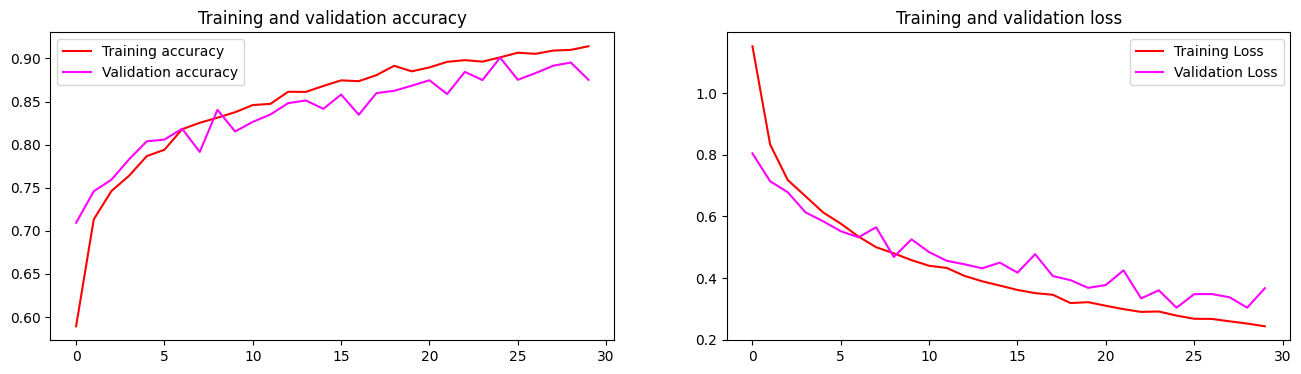

In [18]:
%%time
model.compile(loss='categorical_crossentropy',
          optimizer=AdamW(learning_rate=2e-4,  weight_decay=3e-2),
          metrics=['accuracy'])

# Train the model
history1 = model.fit(
      train_generator,
      epochs=EPOCHS,
      validation_data=validation_generator,
      callbacks=[early_stopping],
      #class_weight=weights
    )

print("Saving the Model")
model.save("DeepWeeds-ResNet50-Model.keras")

# Plot training results
plot_loss_acc(history1.history)

model.evaluate
438/438 [==============================] - 10s 24ms/step - loss: 0.3144 - accuracy: 0.8963
model.predict


  0%|          | 0/438 [00:00<?, ?it/s]

Statistics
F1-Score 0.9023636803845007
Precision-Score 0.9038278969556657
Recall-Score 0.9020559680182753
accuracy_Score 0.9020559680182753



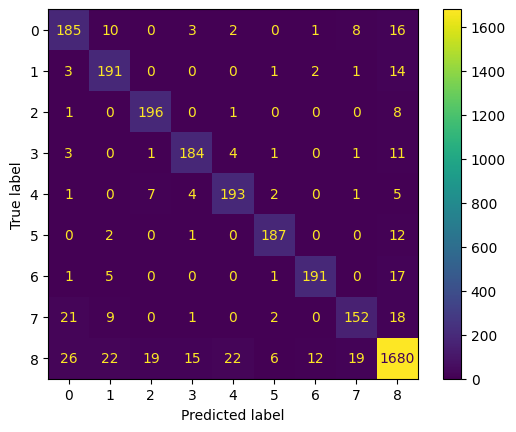

In [19]:
a, b = eval_model(model, validation_generator)

## Trial 2

Epoch 1/100


2024-02-26 11:09:31.069537: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


972/972 [==============================] - 143s 121ms/step - loss: 0.2056 - accuracy: 0.9273 - val_loss: 0.2836 - val_accuracy: 0.9058
Epoch 2/100
972/972 [==============================] - 116s 120ms/step - loss: 0.1705 - accuracy: 0.9395 - val_loss: 0.2924 - val_accuracy: 0.9055
Epoch 3/100
972/972 [==============================] - 116s 119ms/step - loss: 0.1613 - accuracy: 0.9433 - val_loss: 0.2777 - val_accuracy: 0.9078
Epoch 4/100
972/972 [==============================] - 116s 120ms/step - loss: 0.1591 - accuracy: 0.9451 - val_loss: 0.2641 - val_accuracy: 0.9126
Epoch 5/100
972/972 [==============================] - 116s 119ms/step - loss: 0.1500 - accuracy: 0.9505 - val_loss: 0.2780 - val_accuracy: 0.9078
Epoch 6/100
972/972 [==============================] - 116s 120ms/step - loss: 0.1442 - accuracy: 0.9502 - val_loss: 0.2605 - val_accuracy: 0.9106
Epoch 7/100
972/972 [==============================] - 116s 119ms/step - loss: 0.1409 - accuracy: 0.9506 - val_loss: 0.2748 - val_

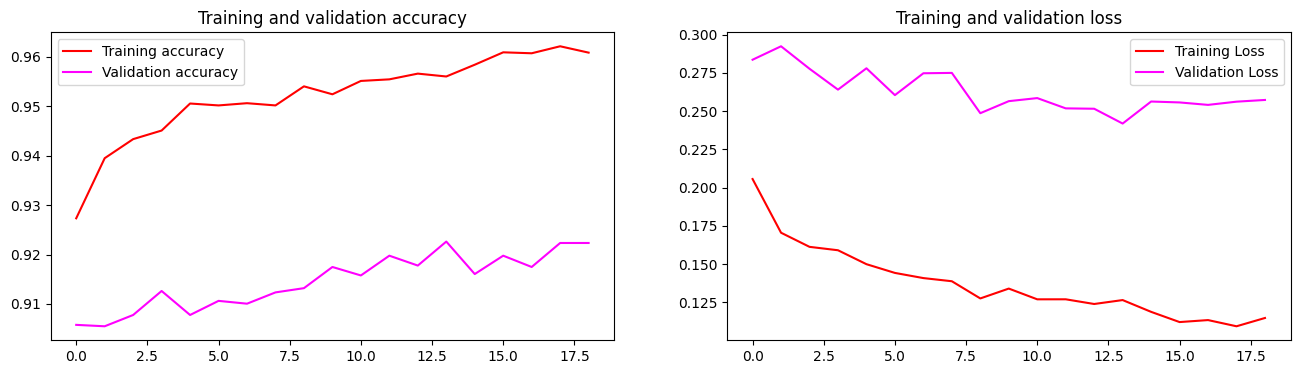

In [20]:
%%time
model.compile(loss='categorical_crossentropy',
          optimizer=AdamW(learning_rate=1e-5,  weight_decay=3e-4),
          metrics=['accuracy'])

# Train the model
history2 = model.fit(
      train_generator,
      epochs=EPOCHS,
      validation_data=validation_generator,
      callbacks=[early_stopping],
    )

print("Saving the Checkpoint")
model.save_weights("DeepWeeds-ResNet50-CheckPoint1.ckpt")

# Plot training results
plot_loss_acc(history2.history)

model.evaluate
438/438 [==============================] - 10s 24ms/step - loss: 0.2641 - accuracy: 0.9180
model.predict


  0%|          | 0/438 [00:00<?, ?it/s]

Statistics
F1-Score 0.9207948777669629
Precision-Score 0.9216324209468144
Recall-Score 0.9203312392918332
accuracy_Score 0.9203312392918332



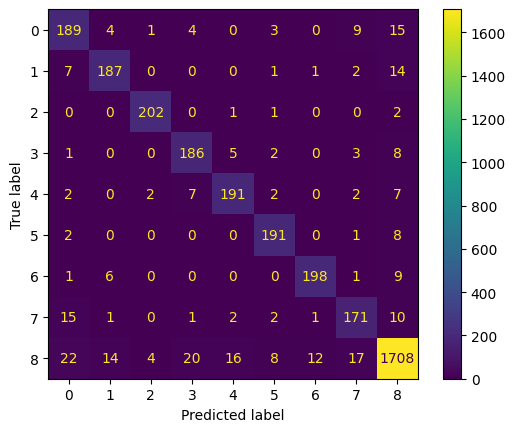

In [21]:
a, b = eval_model(model, validation_generator)

### Trial 3

Epoch 1/100


2024-02-26 11:47:16.079219: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


972/972 [==============================] - 144s 121ms/step - loss: 0.1220 - accuracy: 0.9572 - val_loss: 0.2725 - val_accuracy: 0.9138
Epoch 2/100
972/972 [==============================] - 116s 120ms/step - loss: 0.1173 - accuracy: 0.9577 - val_loss: 0.2429 - val_accuracy: 0.9215
Epoch 3/100
972/972 [==============================] - 117s 120ms/step - loss: 0.1159 - accuracy: 0.9604 - val_loss: 0.2486 - val_accuracy: 0.9203
Epoch 4/100
972/972 [==============================] - 116s 119ms/step - loss: 0.1104 - accuracy: 0.9608 - val_loss: 0.2491 - val_accuracy: 0.9183
Epoch 5/100
972/972 [==============================] - 116s 119ms/step - loss: 0.1125 - accuracy: 0.9607 - val_loss: 0.2391 - val_accuracy: 0.9200
Epoch 6/100
972/972 [==============================] - 115s 119ms/step - loss: 0.1115 - accuracy: 0.9594 - val_loss: 0.2377 - val_accuracy: 0.9198
Epoch 7/100
972/972 [==============================] - 116s 119ms/step - loss: 0.1109 - accuracy: 0.9615 - val_loss: 0.2367 - val_

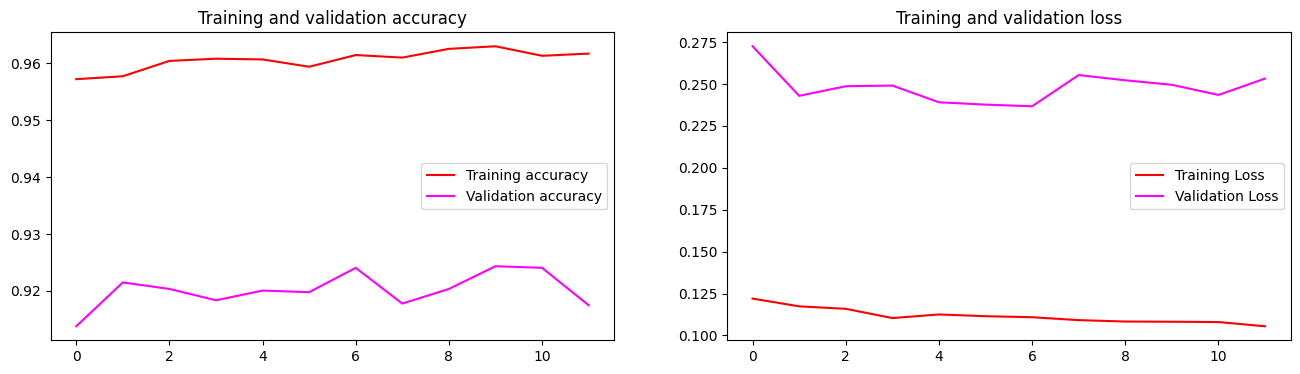

In [22]:
%%time
# weights = getWeightedClass(data_info, 1/2)
# print("Increasing Class-Weights",weights)

model.compile(loss='categorical_crossentropy',
  optimizer=AdamW(learning_rate=5e-6,  weight_decay=3e-5),
  metrics=['accuracy'])

# Train the model
history3 = model.fit(
      train_generator,
      epochs=EPOCHS,
      validation_data=validation_generator,
      callbacks=[early_stopping],
      #class_weight=weights
    )

print("Saving the Checkpoint")
model.save_weights("DeepWeeds-ResNet50-CheckPoint2.ckpt")

# Plot training results
plot_loss_acc(history3.history)

## Trial 4

Freezing layer resnet50v2
Epoch 1/100


2024-02-26 12:10:47.133307: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


972/972 [==============================] - 52s 48ms/step - loss: 0.2246 - accuracy: 0.9204 - val_loss: 0.1900 - val_accuracy: 0.9429
Epoch 2/100
972/972 [==============================] - 46s 47ms/step - loss: 0.2256 - accuracy: 0.9213 - val_loss: 0.1912 - val_accuracy: 0.9420
Epoch 3/100
972/972 [==============================] - 45s 47ms/step - loss: 0.2166 - accuracy: 0.9251 - val_loss: 0.1920 - val_accuracy: 0.9412
Epoch 4/100
972/972 [==============================] - 45s 46ms/step - loss: 0.2100 - accuracy: 0.9255 - val_loss: 0.1929 - val_accuracy: 0.9412
Epoch 5/100
972/972 [==============================] - 45s 46ms/step - loss: 0.2023 - accuracy: 0.9292 - val_loss: 0.1948 - val_accuracy: 0.9400
Epoch 6/100
972/972 [==============================] - 45s 47ms/step - loss: 0.2046 - accuracy: 0.9303 - val_loss: 0.1962 - val_accuracy: 0.9397
Epoch 6: early stopping
Saving the Checkpoint


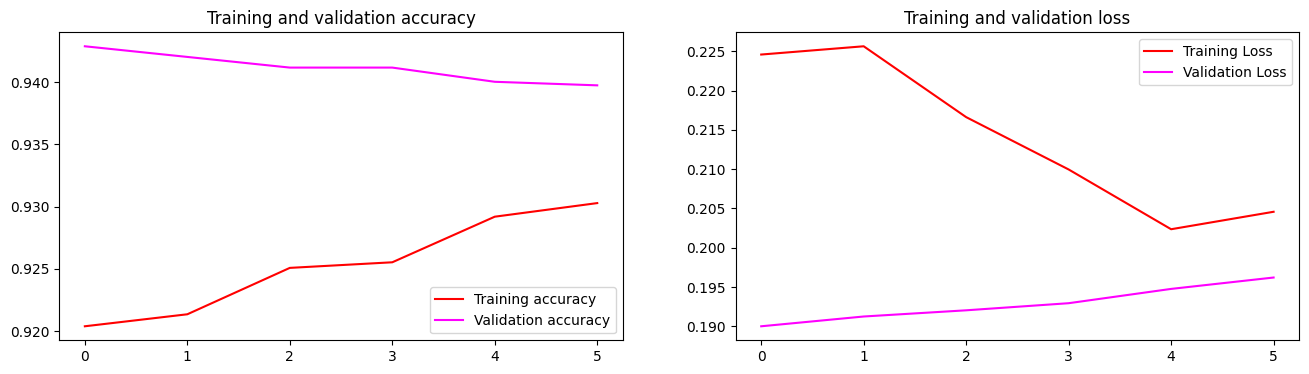

In [23]:
%%time
for layer in model.layers:
    if layer.name == 'resnet50v2':
        print("Freezing layer", layer.name)
        layer.trainable = False
        
model.compile(loss='categorical_crossentropy',
  optimizer=AdamW(learning_rate=1e-6,  weight_decay=1e-5),
  metrics=['accuracy'])

# Train the model
history4 = model.fit(
      train_generator,
      epochs=EPOCHS,
      validation_data=validation_generator,
      callbacks=[early_stopping]
    )

print("Saving the Checkpoint")
model.save_weights("DeepWeeds-ResNet50-CheckPoint3.ckpt")

# Plot training results
plot_loss_acc(history4.history)

# Evaluations

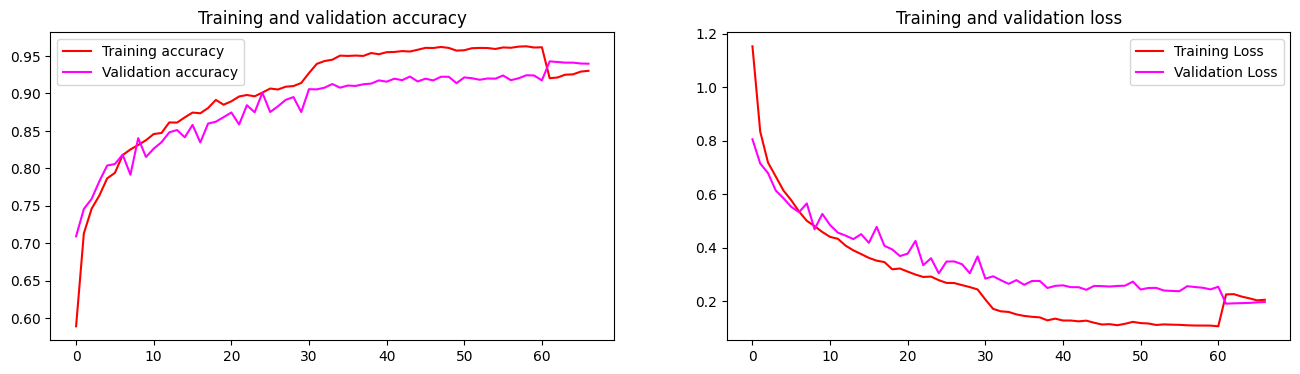

In [24]:
import copy

history = copy.deepcopy(history1.history)

for key in history:
    history[key].extend(history2.history[key])
    history[key].extend(history3.history[key])
    history[key].extend(history4.history[key])
    

plot_loss_acc(history)

model.evaluate
438/438 [==============================] - 9s 21ms/step - loss: 0.1900 - accuracy: 0.9429
model.predict


  0%|          | 0/438 [00:00<?, ?it/s]

Statistics
F1-Score 0.9432544110742392
Precision-Score 0.9445023644539781
Recall-Score 0.9428897772701313
accuracy_Score 0.9428897772701313



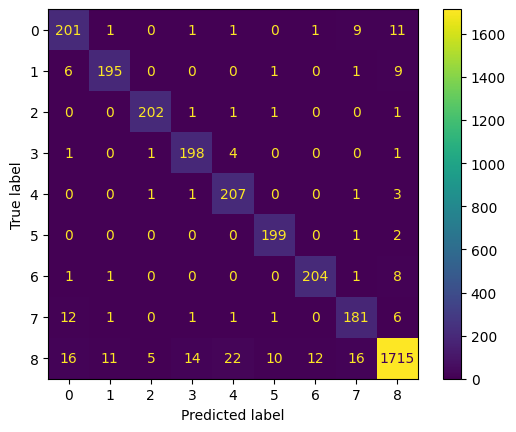

'Threshold = 0.1111111119389534'

In [25]:
## Computing Positive Threshold Using Validation Dataset
a, b = eval_model(model,validation_generator)

thresholds = []
for i in range(len(a)):
    n_label = prediction_argmax(b[i])
    ap_label = np.argmax(b[i])
    a_label = a[i]

    if(n_label == a_label):
        thresholds.append(b[n_label])


rand_guess = np.mean(thresholds)
"Threshold = {}".format(rand_guess)

## Normal Evaluation

Normal Evaluation   
--------------------------------------------------------------------
model.evaluate
438/438 [==============================] - 11s 24ms/step - loss: 0.2070 - accuracy: 0.9406
model.predict


  0%|          | 0/438 [00:00<?, ?it/s]

Statistics
F1-Score 0.9410056497954795
Precision-Score 0.9426651169261845
Recall-Score 0.940588403313339
accuracy_Score 0.940588403313339



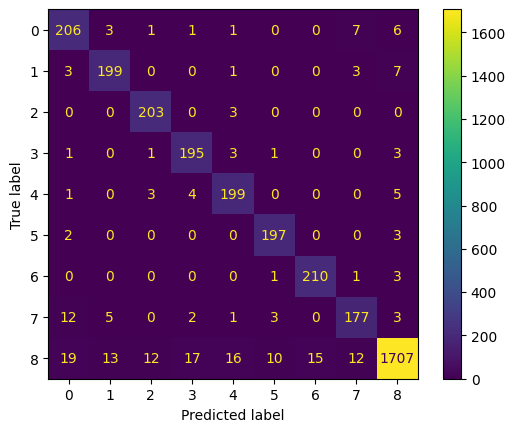

In [26]:
print("Normal Evaluation \
  \n--------------------------------------------------------------------")
a, b = eval_model(model, test_generator)

In [27]:
prediction = [np.argmax(x) for x in b]
per_class_accuracy = [0,0,0,0,0,0,0,0,0]
per_class_total = [0,0,0,0,0,0,0,0,0]
for i in range(len(a)):
    per_class_total[a[i]]+=1
    if a[i] == prediction[i]:
        per_class_accuracy[a[i]] += 1


print("Predictions",per_class_accuracy)
print("Actual",per_class_total)
print("Per Class Accuracy")
np.array(per_class_accuracy) / np.array(per_class_total)

Predictions [206, 199, 203, 195, 199, 197, 210, 177, 1707]
Actual [225, 213, 206, 204, 212, 202, 215, 203, 1821]
Per Class Accuracy


array([0.91555556, 0.9342723 , 0.98543689, 0.95588235, 0.93867925,
       0.97524752, 0.97674419, 0.87192118, 0.93739703])

## Random Guess Threshold
> As applied by the paper DeepWeeds

Evaluation with Random Guess - As applied by the paper DeepWeeds   
--------------------------------------------------------------------
Statistics
F1-Score 0.9264377504836968
Precision-Score 0.9321752508700574
Recall-Score 0.9251642387889174
accuracy_Score 0.9251642387889174



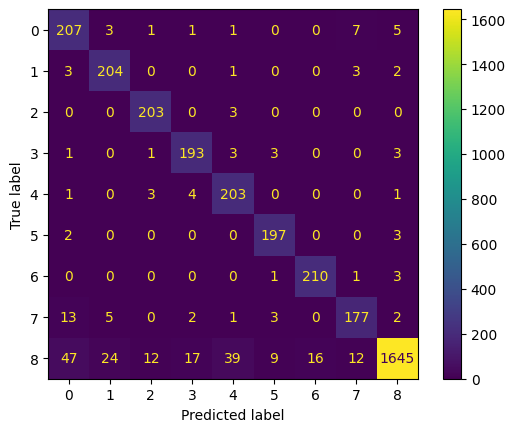

In [28]:
print("Evaluation with Random Guess - As applied by the paper DeepWeeds \
  \n--------------------------------------------------------------------")
printStats(a,b,rand_guess)

In [29]:
prediction = [prediction_argmax(x) for x in b]
per_class_accuracy = [0,0,0,0,0,0,0,0,0]
per_class_total = [0,0,0,0,0,0,0,0,0]
for i in range(len(a)):
    per_class_total[a[i]]+=1
    if a[i] == prediction[i]:
        per_class_accuracy[a[i]] += 1


print("Predictions",per_class_accuracy)
print("Actual",per_class_total)
print("Per Class Accuracy")
np.array(per_class_accuracy) / np.array(per_class_total)

Predictions [206, 199, 203, 195, 199, 197, 210, 177, 1707]
Actual [225, 213, 206, 204, 212, 202, 215, 203, 1821]
Per Class Accuracy


array([0.91555556, 0.9342723 , 0.98543689, 0.95588235, 0.93867925,
       0.97524752, 0.97674419, 0.87192118, 0.93739703])

In [30]:
shutil.rmtree(base_dir)